In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

%matplotlib inline

# Using the "Reds" palette
sns.set_palette("Reds")

In [3]:
# Reload the dataset
kpi_df = pd.read_csv('../data/clean/df_cleaned.csv')

### COMPLETION RATE KPI

In [6]:
# Filter data by unique clients and process steps
total_users = kpi_df['client_id'].nunique()

# Count users who completed the process (reached 'confirm')
completed_users = kpi_df[kpi_df['process_step'] == 'confirm']['client_id'].nunique()

# Calculate overall completion rate
completion_rate_overall = completed_users / total_users

# Calculate completion rates for Test and Control groups
completed_users_by_group = kpi_df[kpi_df['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()
total_users_by_group = kpi_df.groupby('Variation')['client_id'].nunique()
completion_rate_by_group = completed_users_by_group / total_users_by_group

# Present the results
completion_rate_overall, completion_rate_by_group

(0.6756462315539269,
 Variation
 Control    0.655785
 Test       0.692978
 Name: client_id, dtype: float64)

In [110]:
total_users_by_group, completed_users_by_group

(Variation
 Control    23464
 Test       26873
 Name: client_id, dtype: int64,
 Variation
 Control    15347
 Test       18580
 Name: client_id, dtype: int64)

In [38]:
# Convert overall and group-specific completion rates to percentages
completion_rate_overall_percentage = completion_rate_overall * 100
completion_rate_by_group_percentage = completion_rate_by_group * 100

# Display the results
completion_rate_overall_percentage, completion_rate_by_group_percentage

(67.5646231553927,
 Variation
 Control    65.578509
 Test       69.297823
 Name: client_id, dtype: float64)

### The percentage of all participants getting to the confirm stage is 68%, for the control group, 66% and 69% for the test group

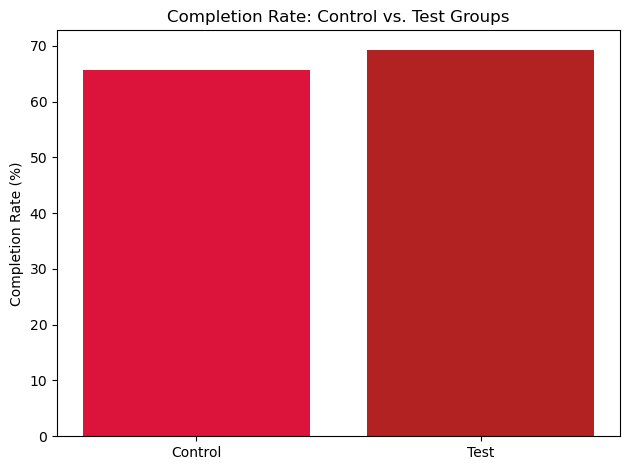

In [65]:
# Use the index and values from the Series for the plot
plt.bar(completion_rate_by_group_percentage.index, 
        completion_rate_by_group_percentage.values, 
        color=['crimson', 'firebrick'])

# Add labels, title, and formatting
plt.ylabel('Completion Rate (%)')
plt.title('Completion Rate: Control vs. Test Groups')
plt.tight_layout()

# Save the plot as an image
plt.savefig("../figures/completion_rate.jpeg", format="jpeg", dpi=300)

# Show the plot
plt.show()


### TIME SPENT ON EACH STEP KPI

In [17]:
# Convert 'date_time' to a datetime object
kpi_df['date_time'] = pd.to_datetime(kpi_df['date_time'])

# Sort data by 'visit_id' and 'date_time'
kpi_df = kpi_df.sort_values(by=['visit_id', 'date_time'])

# Calculate time differences for consecutive steps
kpi_df['time_diff'] = kpi_df.groupby('visit_id')['date_time'].diff().dt.total_seconds()

# Ensure only the last 'confirm' step is considered
kpi_df = kpi_df.iloc[::-1].drop_duplicates(subset=['visit_id', 'process_step'], keep='first').iloc[::-1]

# Aggregate average time spent per step
average_time_per_step = kpi_df.groupby('process_step')['time_diff'].mean().round().reindex(['start', 'step_1', 'step_2', 'step_3', 'confirm']).astype(int)

# Create a DataFrame for display
average_time_per_step_df = average_time_per_step.reset_index(name='average_time_spent')

# Display the DataFrame to the user
display(average_time_per_step_df)


,process_step,average_time_spent
0,start,214
1,step_1,49
2,step_2,52
3,step_3,100
4,confirm,142


In [19]:
# Step 5: Aggregate average time spent per step for each group (Control and Test)
average_time_by_group = kpi_df.groupby(['Variation', 'process_step'])['time_diff'].mean().unstack(level=0)

# Reindex to ensure the order of steps is consistent
average_time_by_group = average_time_by_group.round().reindex(['start', 'step_1', 'step_2', 'step_3', 'confirm']).astype(int)

# Convert to a DataFrame for display
average_time_by_group_df = average_time_by_group.reset_index()

# Display the DataFrame to the user
(average_time_by_group_df)

Variation,process_step,Control,Test
0,start,281,179
1,step_1,52,47
2,step_2,52,52
3,step_3,98,102
4,confirm,139,144


### On average, the control group spent more time on each stage, especially on the 'start' stage.

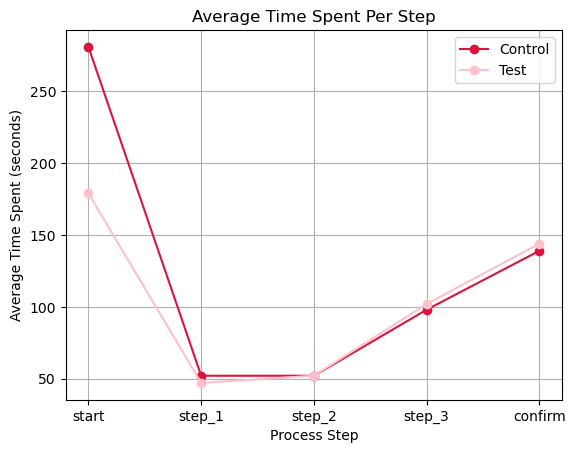

In [69]:
# Plot using the index and columns directly
plt.plot(average_time_by_group.index, average_time_by_group['Control'], marker='o', label='Control', color = 'crimson')
plt.plot(average_time_by_group.index, average_time_by_group['Test'], marker='o', label='Test', color = 'pink')

# Add labels, title, and grid
plt.xlabel('Process Step')
plt.ylabel('Average Time Spent (seconds)')
plt.title('Average Time Spent Per Step')
plt.legend()
plt.grid(visible=True)

# Save the plot as an image
plt.savefig("../figures/avg_time_spent.jpeg", format="jpeg", dpi=300)

# Show the plot
plt.show()


### ERROR RATES KPI

In [29]:
# Sort data by visit_id and date_time to ensure chronological order
kpi_df = kpi_df.sort_values(by=['visit_id', 'date_time'])

# Create a numeric column for process_step to facilitate comparisons
step_mapping = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
kpi_df['process_step_numeric'] = kpi_df['process_step'].map(step_mapping)

# Identify "backward" steps (errors)
kpi_df['prev_process_step'] = kpi_df.groupby('visit_id')['process_step_numeric'].shift(1)
kpi_df['backward_step'] = kpi_df['process_step_numeric'] < kpi_df['prev_process_step']

# Count backward steps and total steps for each Variation
error_data = kpi_df.groupby('Variation').agg(
    backward_steps=('backward_step', 'sum'),
    total_steps=('process_step_numeric', 'count')
).reset_index()

# Calculate error rates
error_data['error_rate'] = error_data['backward_steps'] / error_data['total_steps']

(error_data)


,Variation,backward_steps,total_steps,error_rate
0,Control,3613,108691,0.033241
1,Test,6802,129512,0.052520


In [31]:
# Convert error rates to percentages
error_data['error_rate_percentage'] = error_data['error_rate'] * 100

# Update the displayed dataframe to include the percentage column
(error_data)

,Variation,backward_steps,total_steps,error_rate,error_rate_percentage
0,Control,3613,108691,0.033241,3.324102
1,Test,6802,129512,0.052520,5.252023


### The test group experienced about 2% more errors than the control group 

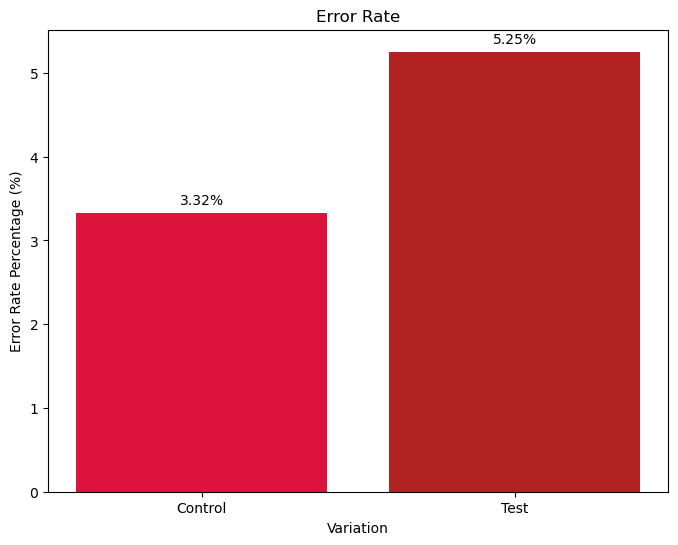

In [67]:
# Plot the bar chart using error_data
plt.bar(error_data['Variation'], error_data['error_rate_percentage'], color=['crimson', 'firebrick'])

# Add labels and title
plt.xlabel('Variation')
plt.ylabel('Error Rate Percentage (%)')
plt.title('Error Rate')

# Add percentage labels on top of each bar
for i, value in enumerate(error_data['error_rate_percentage']):
    plt.text(i, value + 0.1, f"{value:.2f}%", ha='center', fontsize=10)

# Save the plot as an image
plt.savefig("../figures/error_rate.jpeg", format="jpeg", dpi=300)

# Show the plot
plt.show()